In [1]:
!pip install git+https://github.com/cuongvng/neural-networks-with-PyTorch.git

  Cloning https://github.com/cuongvng/neural-networks-with-PyTorch.git to /tmp/pip-req-build-h5vfwmrc
  Running command git clone -q https://github.com/cuongvng/neural-networks-with-PyTorch.git /tmp/pip-req-build-h5vfwmrc
  Created wheel for train-plot-utils: filename=train_plot_utils-1.0-cp36-none-any.whl size=4827 sha256=5a510a81ced4fe1d3f42c11c31626a04b826753d69f7f46b4a846ab096285a25
  Stored in directory: /tmp/pip-ephem-wheel-cache-qo2byvjv/wheels/72/21/a6/2c9910e6fda85ce86b2c6a011cbc2f3eff8020634fa90e427e
Successfully built train-plot-utils


In [3]:
!nvidia-smi

Fri Jun 12 16:04:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("../..")
from utils.training_helpers import train_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Dataset: CIFAR 10, resize image to 224x224

In [4]:
transform = transforms.Compose([transforms.Resize((224,224)), # Resize tensor từ 32x32 thành 224x224 để phù hợp với đầu vào của AlexNet
                                transforms.ToTensor() # chuyển ảnh đang ở dạng PIL image thành tensor
                                ]) 
cifar_train = torchvision.datasets.CIFAR10(root="../data/", train=True, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)
cifar_test = torchvision.datasets.CIFAR10(root="../data/", train=False, 
                                     transform=transform, 
                                     target_transform=None, 
                                     download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=cifar_train,
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=cifar_test,
    batch_size=128,
    shuffle=True,

)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


Hãy xem thử dữ liệu có dạng như thế nào?

In [0]:
train_iter = iter(train_loader)
x, y = train_iter.next()
print(x.size())

torch.Size([128, 3, 224, 224])


Define the Network architechture

<figure>
    <img src="https://github.com/cuongvng/neural-networks-with-PyTorch/blob/master/CNNs/AlexNet/img/AlexNetArchitecture.png?raw=1" width="25%" class="center"/>
    <figcaption>Cấu trúc mạng AlexNet</figcaption>
</figure>

In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__() # Gọi hàm __init__() của `nn.Module`
        
        # Sau đó định nghĩa các tầng Conv2d trong mạng tại đây luôn.
        # Khối MaxPool không cần định nghĩa, ta thực hiện phép toán đó tại phương thức `forward`.
        
        # Tầng đầu tiên trên hình, 11x11 Conv2d 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        # Tương tự với các tầng Conv2d tiếp theo, số kênh đầu ra của tầng trước là số kênh đầu vào
        # của tầng hiện tại:
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        
        # Đến 3 tầng kết nối đầy đủ (Fully-connected Layer, hay Dense). 
        # Xác định đối số `in_features` cho tầng thứ nhất bằng tích số kênh tầng Conv2d cuối (conv5) 
        # với kích thước ảnh sau tầng đó.
        
        self.fc1 = nn.Linear(in_features=384*2*2, out_features=4096) # Chỗ này có cách lấy `in_features` mà ko cần tính toán nhức đầu
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        
        # Tầng FC cuối cùng, đối số out_features ở đây bằng số lượng nhãn trong MNIST dataset, là 10, 
        # không phải 1000 như hình trên (hình trong paper gốc).
        self.fc3 = nn.Linear(in_features=4096, out_features=10)

    def forward(self, X):
        # Hàm này định nghĩa cách ảnh đầu vào X (dạng tensor) được truyền qua từng tầng của mạng.
        X = X.type(torch.float) # chuyển kiểu từ int sang float

        X = F.relu(self.conv1(X))
        X = torch.max_pool2d(X, kernel_size=3, stride=2)
        X = F.relu(self.conv2(X))
        X = torch.max_pool2d(X, kernel_size=3, stride=2)
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X, kernel_size=3, stride=2)
#         print(X.size()) # In dòng này để tính shape cho tầng fc1.
        
        X = torch.flatten(X, start_dim=1) # Làm phẳng tensor 4D thành tensor 2D để đưa vào tầng FC.
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        # Sử dụng hàm kích hoạt `softmax` ở tầng cuối cùng để tính xác suất 10 nhãn đầu ra.
        X = F.softmax(self.fc3(X))
        return X

In [0]:
# X = torch.randn((1,3,224,224))
# y=AlexNet()(X)

In [6]:
net = AlexNet()
net.to(device)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1536, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

In [0]:
# Thử in ra kích thước các tham số của mạng
for i, p in enumerate(net.parameters()):
    print(i, p.size())

0 torch.Size([96, 3, 11, 11])
1 torch.Size([96])
2 torch.Size([256, 96, 5, 5])
3 torch.Size([256])
4 torch.Size([384, 256, 3, 3])
5 torch.Size([384])
6 torch.Size([384, 384, 3, 3])
7 torch.Size([384])
8 torch.Size([384, 384, 3, 3])
9 torch.Size([384])
10 torch.Size([4096, 1536])
11 torch.Size([4096])
12 torch.Size([4096, 4096])
13 torch.Size([4096])
14 torch.Size([10, 4096])
15 torch.Size([10])


Define the loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.01)

Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored

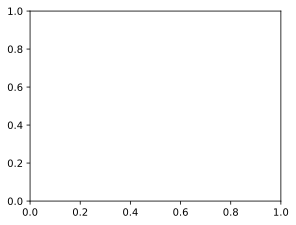

In [8]:
n_epochs = 10
train_cnn(net, device, train_loader, test_loader, optimizer, criterion, n_epochs)